## Analysing data 2014 - 2018: Do combined TTC delays increase during winter and decrease during summer? 

    - Note to TTC and Toronto Open Data: Please save the city's data in CSV format. By saving 
    in xlsx format, you make it cumbersome to aggregate data (especially when some of the data is 
    encoded in utf-8 and others in latin-1!)

    - To see how I got to this stage, look at snow_delay for explanations on what the code does
    
    - This notebook will be an initial analysis on four years of snowfall and TTC delay data
    
    - Hypothesis: Combined TTC delays increase during winter as a result of increased snowfall
      and decrease during summer when there is no snowfall
   

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import requests
import json
import csv

In [2]:
# Load weather data
weather_source = "weather_data/2014_2018_weather.csv"
weather_df = pd.read_csv(weather_source)
weather_df = weather_df[['Date/Time', 'Mean Temp (°C)', 'Total Precip (mm)', 'Snow on Grnd (cm)']]

# Rename columns
weather_df = weather_df.rename(columns={'Date/Time':'date', 'Mean Temp (°C)':'temp', 'Total Precip (mm)':'precip', 'Snow on Grnd (cm)':'snow'})

# Convert date column into datetime format
weather_df['date'] = pd.to_datetime(weather_df.date)

# Set date as index so it's easier to parse with loc operator
weather_df = weather_df.set_index('date')
weather_df = weather_df.sort_values('date')

# Days with no snowfall are missing in dataset, so fill with 0
weather_df = weather_df.fillna(0)

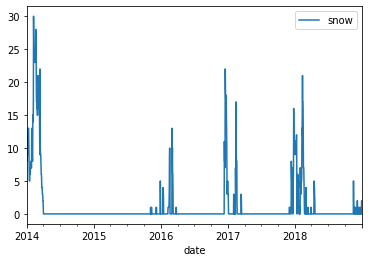

In [3]:
weather_df.plot(y='snow')

### Lots of missing snow data on 2015. This wasn't a parsing/encoding problem — the GOC reports missing snow depth values for 2015

### Lets load the TTC data

    - This time we are using both streetcar and bus delay data, which will require
    a bit more processing to join the two sources of data

In [4]:
# Specify columns to import
fields = ['Report Date', 'Min Delay']

# Load streetcar and bus delay data
streetcar_delay_source = "ttc_data/streetcar_delay.csv"
bus_delay_source = "ttc_data/bus_delays.csv"

# Change date info to datetime
streetcar_df = pd.read_csv(streetcar_delay_source, usecols=fields)
streetcar_df['Report Date'] = pd.to_datetime(streetcar_df['Report Date'])

bus_df = pd.read_csv(bus_delay_source, usecols=fields)
bus_df['Report Date'] = pd.to_datetime(bus_df['Report Date'])



In [5]:
# Multiple delay data points per day, so aggregate to return combined delay for each day

streetcar_df = streetcar_df.groupby(['Report Date']).sum()
streetcar_df = streetcar_df.sort_index()

bus_df = bus_df.groupby(['Report Date']).sum()
bus_df = bus_df.sort_index()

In [6]:
bus_df = bus_df.rename(columns={'Min Delay': 'Min Delay Bus'})

### Lets concatenate two data frames: bus delay and streetcar delay

In [7]:
delay_df = pd.concat([bus_df, streetcar_df], axis=1)
delay_df = pd.concat([bus_df, streetcar_df], axis=1)
delay_df = delay_df.fillna(0)

### Now let's create a new column with the sums of bus and streetcar delays to get a combined delay

In [8]:
delay_df['Combined Delay'] = delay_df['Min Delay Bus'] + delay_df['Min Delay']
delay_df = delay_df[['Combined Delay']]
delay_df[['Combined Delay']] = delay_df[['Combined Delay']] / 10

### Finally, lets do some plotting!

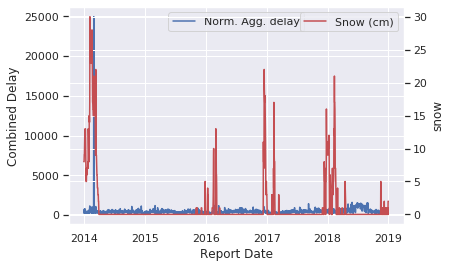

In [9]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= delay_df.reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.reset_index(), ax=ax2, color='r', label='Snow (cm)')

ax.legend(loc= 'upper center')
plt.show()

### You can see that anomalous delay data in 2014 is throwing off the scale of the rest of the delay data
    - Lets verify the mean delay times to help scale our graph

In [10]:
delay_df.loc['2014'].mean()
delay_df.loc['2018'].mean()

Combined Delay    611.733151
dtype: float64

In [11]:
delay_df.loc[delay_df.idxmax()]

,Combined Delay
Report Date,
2014-03-01,24946.4


### Running the summary statistics showed that the mean is between 400 - 600 minutes
    - The max delay however was 24946 minutes in 2014... Was that a freak incident or a data error?

In [12]:
streetcar_df.loc['2014-03-01']
bus_df.loc['2014-03-01']

Min Delay Bus    249290.0
Name: 2014-03-01 00:00:00, dtype: float64

### Smells like a data error
    - A search of the TTC news website for March 3 2014 yielded no results (https://www.ttc.ca/News/2014/March/index.jsp)
    - Mighty Google search on March 2014 yields no results to point to a catastrophic breakdown on March 3 2014
    - Lets change the data to the mean of that month and note it down as a limitation

In [13]:
delay_df.loc['2014-03-01'] = delay_df.loc['2014-03'].mean()

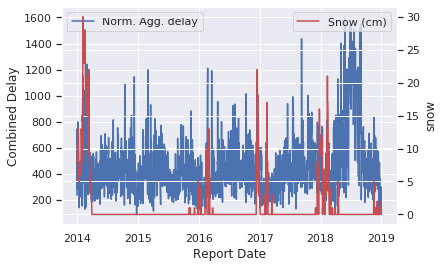

In [14]:
# Replotting based on new data

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= delay_df.reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.reset_index(), ax=ax2, color='r', label='Snow (cm)')

ax.legend()
plt.show()



### Pictured above is 4 years of delay and snowfall data

#### This data, aside from giving us a broad overview, is not too useful:
    - The visualization is cluttered
    - There do seem to be peaks and troughs, but we need to change the x-axis scale to gain more insight
    - Perhaps, separating the data by year will be useful?
    - ylim for snow data will be set at the max of dataset which is 30


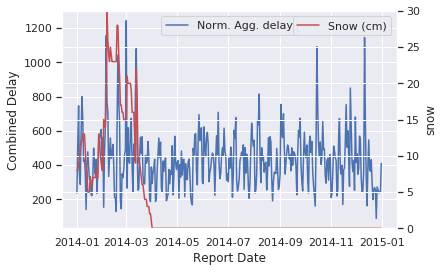

In [16]:
# 2014 data

# Note how 'loc' is a super powerful operator that allows us to zoom in and out of the data!

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= delay_df.loc['2014'].reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.loc['2014'].reset_index(), ax=ax2, color='r', label='Snow (cm)')
ax2.set(ylim=(0,30))
ax.legend(loc='upper center')
plt.show()

### 2014: Note how the highest delays in winter match spikes in snowfall

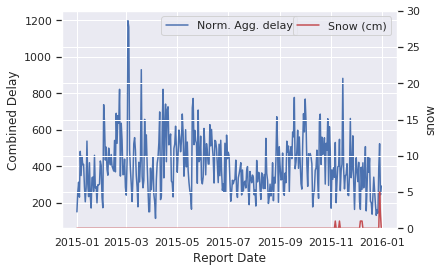

In [17]:
# 2015 data 

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= delay_df.loc['2015'].reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.loc['2015'].reset_index(), ax=ax2, color='r', label='Snow (cm)')
ax2.set(ylim=(0,30))
ax.legend(loc='upper center')
plt.show()

### 2015: Unfortunately, GOC didn't collect snowfall data that year

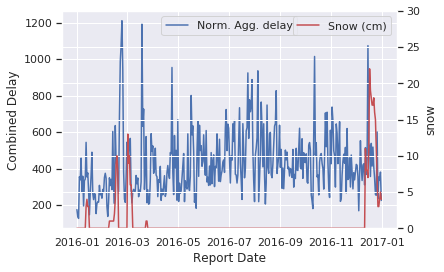

In [18]:
# 2016 data

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= delay_df.loc['2016'].reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.loc['2016'].reset_index(), ax=ax2, color='r', label='Snow (cm)')
ax2.set(ylim=(0,30))
ax.legend(loc='upper center')
plt.show()

### 2016: This data is a bit more confusing
    - Higher peaks in delay time during snow, but average delay seems quite high during non-precipitation months
    - One thing to note is the spike in snowfall and delay during December

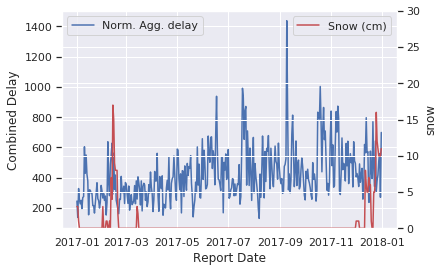

In [19]:
# 2017 data

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= delay_df.loc['2017'].reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.loc['2017'].reset_index(), ax=ax2, color='r', label='Snow (cm)')
ax2.set(ylim=(0,30))
ax.legend(loc='upper center')
plt.show()

### 2017 TTC seems to be doing really good despite sudden spikes in snowfall
    
    - Summer performance seems to be alot worse than winter

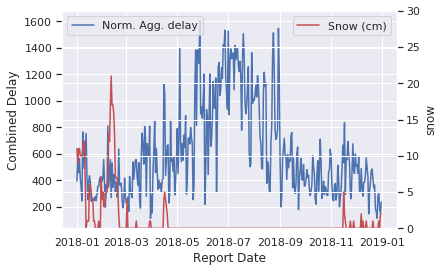

In [20]:
# 2018 data

ax = sns.lineplot(x='Report Date', y='Combined Delay', data= delay_df.loc['2018'].reset_index(), label='Norm. Agg. delay')

ax2 = ax.twinx()
ax2 = sns.lineplot(x='date', y='snow', data= weather_df.loc['2018'].reset_index(), ax=ax2, color='r', label='Snow (cm)')
ax2.set(ylim=(0,30))
ax.legend()
plt.show()

### 2018 TTC performed far worse during the summer months as opposed to the winter months

### Let's correlate weather and TTC delay data

In [21]:
# Concatenate weather_df and delay_df

delay_snow_df = pd.concat([delay_df, weather_df], axis=1)

# Let's drop 2015 data since no snow was recorded by the GOC that month

# Dropping using just 'loc' doesn't work since loc returns a dataframe and pd.drop()
# only accepts a list of labels. df.index returns a list of index labels which can
# be passed to pd.drop()

delay_snow_df = delay_snow_df.drop(delay_snow_df.loc['2015'].index)

In [22]:
delay_snow_df.corr()

,Combined Delay,temp,precip,snow
Combined Delay,1.000000,0.260422,0.104073,-0.001554
temp,0.260422,1.000000,0.063843,-0.463814
precip,0.104073,0.063843,1.000000,-0.021850
snow,-0.001554,-0.463814,-0.021850,1.000000


### No relationship between snow and combined delay

    - It looks like there is no relationship between combined delay and snow
    - In fact, higher delay times correlate positively with temp: higher temp -> higher combined delay
        - Revisiting the data visually seems to *potentially support this...
    - Is it possible that TTC performance varies more intensely during winter?

### Let's calculate the combined delay mean for each month and plot against time
    - This should show if delay trends up or down


In [83]:
group_month = delay_snow_df.groupby([delay_snow_df.index.year.values, delay_snow_df.index.month.values]).sum()

Text(0, 0.5, 'Combined Delay Minutes')

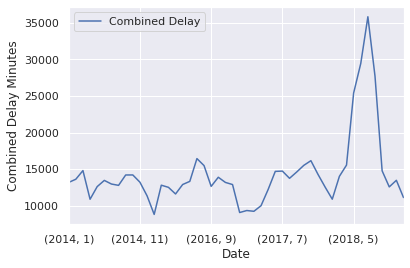

In [93]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

month_plot = group_month['Combined Delay'].plot(legend=True)


month_plot.set_xlabel('Date')
month_plot.set_ylabel('Combined Delay Minutes')


#### Plotting in this way doesn't give us the option to set the x labels in the way that we want
    - The root of the problem is that we are trying to plot from a groupby object and not a dataframe
    - Groupby object indexes return a list of tuples

In [209]:
# Let's try and plot with Seaborn

# Create a new column with year and month in a separate column. Returns a list of floats.
group_month['x'] = group_month.index.get_level_values(0) + group_month.index.get_level_values(1)/100

In [196]:
# Convert list of date floats into year-month-date string to pass into datetime

date_list = []

for x in group_month.index.get_level_values(0):
    for y in group_month.index.get_level_values(1):
        date_list.append((str(x) + '-' + str(y) + '-' + str(1)))

date_frame = pd.DataFrame(list(set(date_list)))

date_frame = date_frame.rename(columns={0:'dates'})

date_frame['dates'] = pd.to_datetime(date_frame.dates)

date_frame = date_frame.sort_values(by='dates')

In [215]:
# Add previous date time into group month data frame

# Doesn't work...

new_data_frame['Dates'] = date_frame['dates']

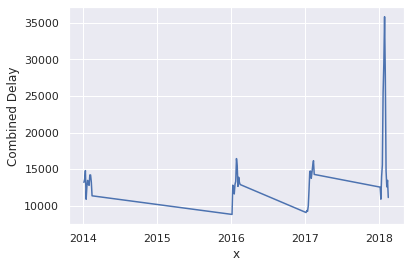

In [151]:
ax = sns.lineplot(x='x', y='Combined Delay', data= new_data_frame.reset_index())

labels = group_month.index.get_level_values(0).astype(str)

plt.show()

In [143]:
new_data_frame.index.get_level_values(0).astype(str)

Index(['2014.01', '2014.02', '2014.03', '2014.04', '2014.05', '2014.06',
       '2014.07', '2014.08', '2014.09', '2014.1', '2014.11', '2014.12',
       '2016.01', '2016.02', '2016.03', '2016.04', '2016.05', '2016.06',
       '2016.07', '2016.08', '2016.09', '2016.1', '2016.11', '2016.12',
       '2017.01', '2017.02', '2017.03', '2017.04', '2017.05', '2017.06',
       '2017.07', '2017.08', '2017.09', '2017.1', '2017.11', '2017.12',
       '2018.01', '2018.02', '2018.03', '2018.04', '2018.05', '2018.06',
       '2018.07', '2018.08', '2018.09', '2018.1', '2018.11', '2018.12'],
      dtype='object', name='x')